# Data Analysis with FugueSQL on Coiled Dask Clusters

In this notebook we will discuss [fugue-sql](https://docs.dask.org/en/latest/dataframe-sql.html#does-dask-implement-sql), a SQL abstraction layer that allows users to run SQL queries on top of Pandas, Spark, and Dask DataFrames. fugue-sql is part of the broader [fugue project](https://github.com/fugue-project/fugue), which aims to be an abstaction layer for distributed compute workflows. Fugue has both a Python and SQL interface. Users can choose the execution engine (Pandas, Spark, Dask) to run their logic on just by specifying during runtime.

FugueSQL is meant for data analysts and SQL lovers to harness the power of distributed compute using a fun, and more English-like, syntax.

<img src="https://raw.githubusercontent.com/fugue-project/fugue/master/images/logo.svg" align="left" width="250"/>

## Import Libaries
Here we import some standard data science libraries.

In [1]:
import pandas as pd
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import coiled

## Creating the Software Environment

The commented out code below was used to create the software environment for our cluster.

In [2]:
coiled.create_software_environment(
    name="fugue-sql",
    conda={"channels": ["conda-forge"],
            "dependencies": ["dask=2021.04.0","distributed=2021.04.0","python=3.7.9","s3fs"]},
    pip=['fugue']
    )

Updating software environment...
Found built software environment


## Creating the Coiled Cluster

We need to create a Coiled cluster with a predefined image. The image contains fugue and some fugue dependencies. If you're doing this in your Coiled account, don't forget to change the software to your account. Instead of `kvnkho/fugue-sql`, it will look like `username/fugue-sql` if the software environment above was used.

In [3]:
# Creating the Coiled cluster
cluster = coiled.Cluster(
    n_workers=2,
    software="kvnkho/fugue-sql",
)
cluster

Output()

Checking environment images
Valid environment image found


Now we pass the cluster to our Dask Client.

In [4]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tls://ec2-3-143-213-11.us-east-2.compute.amazonaws.com:8786 Dashboard: http://ec2-3-143-213-11.us-east-2.compute.amazonaws.com:8787,Cluster Workers: 2 Cores: 8 Memory: 34.36 GB


## Setup

`fugue-sql` can be imported in notebooks by using the `fugue_notebook.setup` function. This provides syntax highlighting for fugue-sql cells and allows us to use the `%%fsql` magic.

At the moment, the syntax highlighting is only available for traditional iPython notebooks. It will fail in JupyterLab environments.

To open the classic iPython Notebook from JupyterLab, select “Launch Classic Notebook” from the JupyterLab Help menu.

In [5]:
from fugue_notebook import setup
try:
    setup()
except:
    print("fugue-sql cell magic will work but syntax highlighting is not yet available for JupyterLab")

## Initial Look at fugue-sql

Here we load in the NYC taxi data with dask. This is a standard dataset frequently used in other Dask demos. Persist prevents re-reading unnecessarily. Some of these columns hold NULL values, so we need to store it float because of compatibility with PyArrow. The integer data type can't hold NULL values in PyArrow.

In [6]:
taxi_df = dd.read_csv(
    "s3://nyc-tlc/trip data/yellow_tripdata_2019-01.csv",
    dtype={'RatecodeID': 'float64',
           'VendorID': 'float64',
           'passenger_count': 'float64',
           'payment_type': 'float64'},
    storage_options={"anon": True},
    blocksize="16 MiB",
).persist()

The next cell is our first look at fugue-sql. Notice the `%%fsql` cell magic turns the whole cell into a SQL cell. `%%fsql dask` tells Fugue to use Dask as an execution engine. Not specifying an execution engine defaults to pandas.

The Dask DataFrame (named `taxi_df`) that was previously loaded in is now accessible by this SQL cell. `fugue-sql` has all ANSI SQL keywords available, so here we show a simple `GROUP BY` and `ORDER BY` to get the average tip by number of passengers. We also use the `AVG` aggregate function.

For iPython notebook users, syntax highlighting for SQL keywords will be available.

In [7]:
%%fsql dask
-- This is a SQL cell
tempdf = SELECT passenger_count, AVG(tip_amount) AS average_tip
           FROM taxi_df
       GROUP BY passenger_count

  SELECT *
    FROM tempdf
ORDER BY passenger_count ASC
   LIMIT 5
   PRINT

,passenger_count,average_tip
0,0.0,1.786901
1,1.0,1.828308
2,2.0,1.833877
3,3.0,1.795579
4,4.0,1.702710


## Basics of fugue-sql

fugue-sql aims to make SQL easier to use. To support end-to-end workflows, some enhancements have been added. One of them is already visible above where we assigned a query to `tempdf` . This is similar to the SQL temp tables and common table expressions (CTEs)

For familiar Dask users, this is a delayed execution that runs when `PRINT` is called. This happens because `fugue-sql` uses Dask, which constructs a Directed Acyclic Graph (DAG) to perform the operations lazily.

### Passing Python DataFrames to fugue-sql

`fugue-sql` supports Python interoperatibility. DataFrames defined outside `%%fsql` cells can be used inside the SQL queries. In this example, we create an example DataFrame and use it inside a following `fugue-sql` code block.

In [8]:
example = pd.DataFrame({'a':[1,2,3],'b':[1,2,3]})

### Passing fugue-sql results to Python

By default, the DataFrames inside fugue-sql cells **will not be accessible** by Python cells (or even by succeeding fugue-sql cells). We have to use the `YIELD DATAFRAME` keyword to make a DataFrame available in memory. For significantly large DataFrames, we can use the `YIELD FILE` keyword. This saves the file in a temporary location and loads it when needed.

In [9]:
%%fsql
SELECT * 
  FROM example
 WHERE a > 1
 YIELD DATAFRAME AS filtered_example

In [10]:
%%fsql
-- Here we can use the YIELDED dataframe
SELECT *
  FROM filtered_example
 PRINT

,a,b
0,2,2
1,3,3


In the cell below, we use the same `YIELDED` DataFrame

In [11]:
# Using a YIELDED dataframe
filtered_example.as_pandas().head()

,a,b
1,2,2
2,3,3


### Load and Save

`fugue-sql`allows users to `LOAD` from csv/json/parquet files using Pandas and Dask under the hood. This means we can load in data, perform transformations on it, and then `SAVE` the results. Data analysts can now work on flat files with a language they are comfortable in. The cell below runs in Pandas because we don't specify the engine after `%%fsql`.

In [12]:
%%fsql
SELECT * FROM example
SAVE OVERWRITE "/tmp/f.csv" (header=TRUE)

loaded_example = LOAD "/tmp/f.csv" (header=TRUE)
PRINT 

,a,b
0,1,1
1,2,2
2,3,3


### Jinja Templating

Sometimes a Python variable will be needed inside a SQL block. Think of dynamic lists used to filter values in a DataFrame. In this case, Jinja templating can be used to pass a variable inside a fsql code block.

In [13]:
# This is a Python cell
n = 1

In [14]:
%%fsql
SELECT *
  FROM example
 WHERE a = {{n}}
 PRINT

,a,b
0,1,1


### Altering Schema

Note that if we don't infer the schema, Pandas loads most columns as strings. We can use `ALTER COLUMNS` to change the schema. For DataFrames with a large number of columns, we recommend using `infer_schema=TRUE` and then `ALTER COLUMNS` to ensure the correct types.

In [15]:
%%fsql
df = LOAD "/tmp/f.csv" (header = TRUE, infer_schema=TRUE)
df = ALTER COLUMNS a:int, b:str FROM df

### Anonymity and Inline

Anonymity is when the DataFrame to perform the operation on is not specified. As a default, the output of the last operation will be used. This is a `fugue-sql` feature designed to simplify code. `PRINT` is an example of this.

Inline statements are wrapping another SQL statement inside parenthesis so that they are evaluated first as part of an outer SQL statement. This is another option instead of assigning DataFrames into variables. Notice the `LOAD` statement below.

In [16]:
%%fsql
df = SELECT * FROM (LOAD "/tmp/f.csv" (header=TRUE))
ALTER COLUMNS a:int, b:double
PRINT 5 ROWS

,a,b
0,1,1.0
1,2,2.0
2,3,3.0


## Sample Data Analysis

Now that we have covered the basics, we will perform a simple analysis and show some more advance features such as integration Python code and utilizing the Dask execution engine more. First we start by displaying the head of our DataFrame.

In [17]:
%%fsql dask
SELECT *
  FROM taxi_df
 LIMIT 10 
 PRINT

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,N,151,239,1.0,7.0,0.5,0.5,1.65,0.00,0.3,9.95,None
1,1.0,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,N,239,246,1.0,14.0,0.5,0.5,1.00,0.00,0.3,16.30,None
2,2.0,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.0,1.0,N,236,236,1.0,4.5,0.5,0.5,0.00,0.00,0.3,5.80,None
3,2.0,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.0,1.0,N,193,193,2.0,3.5,0.5,0.5,0.00,0.00,0.3,7.55,None
4,2.0,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.0,2.0,N,193,193,2.0,52.0,0.0,0.5,0.00,0.00,0.3,55.55,None
5,2.0,2018-11-28 16:25:49,2018-11-28 16:28:26,5.0,0.0,1.0,N,193,193,2.0,3.5,0.5,0.5,0.00,5.76,0.3,13.31,None
6,2.0,2018-11-28 16:29:37,2018-11-28 16:33:43,5.0,0.0,2.0,N,193,193,2.0,52.0,0.0,0.5,0.00,0.00,0.3,55.55,None
7,1.0,2019-01-01 00:21:28,2019-01-01 00:28:37,1.0,1.3,1.0,N,163,229,1.0,6.5,0.5,0.5,1.25,0.00,0.3,9.05,None
8,1.0,2019-01-01 00:32:01,2019-01-01 00:45:39,1.0,3.7,1.0,N,229,7,1.0,13.5,0.5,0.5,3.70,0.00,0.3,18.50,None
9,1.0,2019-01-01 00:57:32,2019-01-01 01:09:32,2.0,2.1,1.0,N,141,234,1.0,10.0,0.5,0.5,1.70,0.00,0.3,13.00,None


## Using Python Functions

Here we will demonstrate using Python functions together with fugue-sql. Below we define a simple function that outputs a plot with the given `x_col` and `y_col`.

In [18]:
def seaborn_barplot(df: pd.DataFrame, x_col:str, y_col:str) -> None:
    plt.figure(figsize=(10,6))
    sns.barplot(df[x_col].astype('str').fillna("None"), df[y_col])
    plt.ylabel(y_col, fontsize=12)
    plt.xlabel(x_col, fontsize=12)
    plt.title(f"{x_col} vs {y_col}", fontsize=15)
    plt.show()

We can then use this function with the `OUTPUT` keyword. The `OUTPUT` keyword is for functions that don't return anything. To avoid passing a lot of data into seaborn, we will `SAMPLE` 10 percent of the data. This is an additional` fugue-sql` keyword. Also note the use of anonymity to use the Python function multiple times on the same DataFrame.

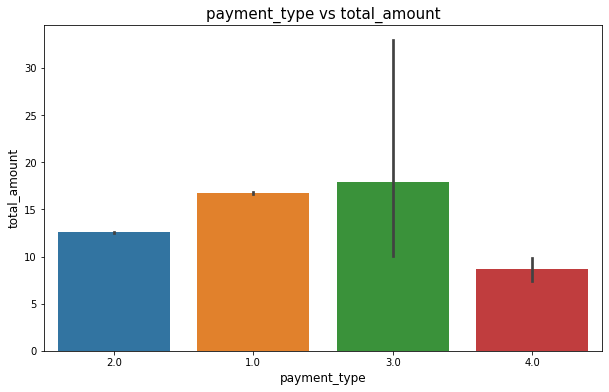

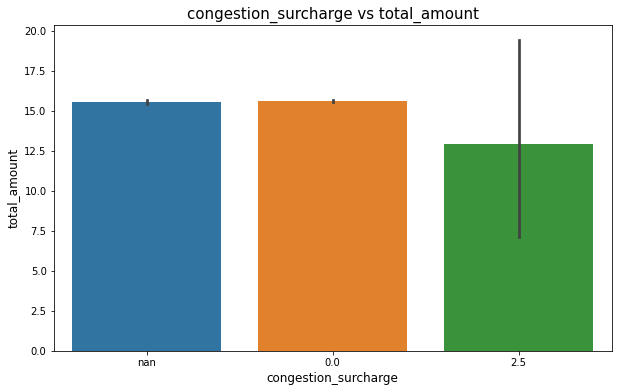

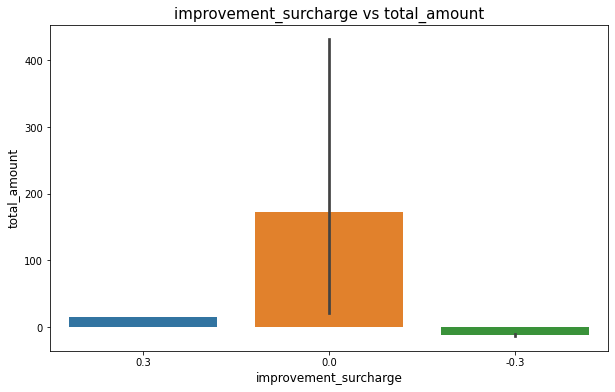

In [19]:
%%fsql dask
SELECT payment_type, total_amount, congestion_surcharge, improvement_surcharge
  FROM taxi_df
SAMPLE 10 PERCENT SEED 42
OUTPUT USING seaborn_barplot PARAMS (x_col:"payment_type", y_col:"total_amount")
OUTPUT USING seaborn_barplot PARAMS (x_col: "congestion_surcharge", y_col:"total_amount")
OUTPUT USING seaborn_barplot PARAMS (x_col: "improvement_surcharge", y_col:"total_amount")

## Control Over Partitions

In the previous plots, there is a weird relationship between **improvement_surcharge** and **total_amount** paid when **improvement_surcharge==0**. We can explore this by looking at the rows with high **total_amount** values.

The `TAKE` keyword lets us return the whole row. We first `PREPARTITION` our data by **improvement_surcharge** values and then get the rows with the top 3 **total_amount** values. fugue-sql allows users to control the partitioning of data.

In [20]:
%%fsql dask
SELECT trip_distance, passenger_count, total_amount, improvement_surcharge
  FROM taxi_df
  TAKE 3 ROWS PREPARTITION BY improvement_surcharge PRESORT total_amount DESC
 PRINT

,trip_distance,passenger_count,total_amount,improvement_surcharge
0,0.00,1.0,356214.78,0.0
1,0.00,0.0,36090.30,0.0
2,0.00,0.0,34674.65,0.0
3,2.40,1.0,623261.66,0.3
4,0.10,1.0,6667.45,0.3
5,21.70,1.0,3345.30,0.3
6,2.57,1.0,13.86,0.6
7,0.00,1.0,-0.31,-0.3
8,0.00,1.0,-0.31,-0.3
9,0.00,0.0,-0.31,-0.3


## Using Custom Python Functions

The previous table hints that there are uneven counts for each `improvement_surcharge` value. We can explore this by using a custom Python function

We define the `value_counts` function below. Note that the schema hint comment is read and enforced to ensure that the output of the function matches the specified schema. 

In [21]:
# schema: value:str, count:int
def value_counts(df: pd.DataFrame, col: str) -> pd.DataFrame:
    out = df[[col]].value_counts().reset_index()
    out.columns = ['value', 'count']
    return out

For functions that return another DataFrame, we use the `TRANSFORM` keyword. The output may be a bit different than expected. Note that we have multiple rows for the same `value`. This is because the function was applied over the default partitions, and returned the output for each partition.

In [22]:
%%fsql dask
SELECT * FROM taxi_df
TRANSFORM USING value_counts PARAMS(col:"improvement_surcharge")
PRINT 6 ROWS

,value,count
0,0.3,187510
1,-0.3,232
2,0.0,86
3,0.3,188497
4,-0.3,201
5,0.0,83


In order to fix the behavrior above, we need to specify the partitioning scheme before the operation is done. This can be specified within the `TRANSFORM` statement.

In [23]:
%%fsql dask
SELECT * FROM taxi_df
TRANSFORM PREPARTITION BY improvement_surcharge 
USING value_counts PARAMS(col:"improvement_surcharge")
PRINT

,value,count
0,0.6,1
1,0.0,2657
2,-0.3,7129
3,0.3,7658005


## Deployment

When ready to move from notebooks to Python scripts, the `fsql()` class can be used. The `run` method takes in the execution engine. If none is provided, Pandas is used. This is the same query used in the previous cell.

In [ ]:
from fugue_sql import fsql
fsql("""SELECT * 
        FROM taxi_df
        TRANSFORM PREPARTITION BY improvement_surcharge 
        USING value_counts PARAMS(col:"improvement_surcharge")
        PRINT""").run("dask")

## Conclusion

Here we have shown an example of using `fugue-sql` with the Dask execution engine. `fugue-sql` is a language to express computation workflows through SQL. The expressed logic can then be run on Pandas, Dask or Spark, without having to change the code. There are enhancements over standard SQL that allow it to be used for full end-to-end workflows.

## More information

We have only scratched the surface of `fugue` and `fugue-sql`. `fugue` is a pure abstraction layer that makes code portable across differing computing frameworks such as Pandas, Spark and Dask. It decouples logic from execution engines, allowing users to write code without worrying about the execution engine. All questions about `fugue` and distributed compute are welcome in the `fugue` Slack channel.

[Fugue Repo](https://github.com/fugue-project/fugue)

[Fugue Slack](https://join.slack.com/t/fugue-project/shared_invite/zt-jl0pcahu-KdlSOgi~fP50TZWmNxdWYQ)